# TopoCluster Regression Rewrite

Here, we are going to write out our topo-cluster regression notebook. Let's start with charged pions, and see what we can do to understand them.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
plotpath = '/home/mswiatlowski/start_tf/caloml-atlas/regression/Plots_rewrite/'
modelpath_c = '/home/mswiatlowski/start_tf/caloml-atlas/classifier/Models/'
modelpath = '/home/mswiatlowski/start_tf/caloml-atlas/regression/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [31]:
# import our resolution utilities

import sys
sys.path.append('/home/mswiatlowski/start_tf/caloml-atlas/')
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu
import uproot as ur

In [4]:
# import pi+

path = '/fast_scratch/atlas_images/v7/'
pp_file = ur.open(path+'piplus.root')
pp_tree = pp_file['ClusterTree']
pp = pp_tree.pandas.df("*", flatten=False)

print("Number of pi+ events: {}".format(len(pp)))

Number of pi+ events: 435967


In [5]:
#define convenience columns

pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT
pp['clusterEoverTruth'] = pp.clusterE / pp.truthE
pp['cluster_ENG_ALL'] = pp.cluster_ENG_CALIB_TOT + pp.cluster_ENG_CALIB_OUT_T + pp.cluster_ENG_CALIB_DEAD_TOT

In [6]:
# regression variables: define up here to make it easier for later swapping

pp['logE'] = np.log(pp.clusterE)
pp['logECalib'] = np.log(pp.cluster_ENG_CALIB_TOT)
pp['logECalibAll'] = np.log(pp.cluster_ENG_ALL)

In [7]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_e = StandardScaler()
scaler_cal = StandardScaler()
scaler_calAll = StandardScaler()
# fit and transform in one step
pp['s_logE'] = scaler_e.fit_transform(pp['logE'].to_numpy().reshape(-1,1))
pp['s_logECalib'] = scaler_cal.fit_transform(pp['logECalib'].to_numpy().reshape(-1,1))
pp['s_logECalibAll'] = scaler_calAll.fit_transform(pp['logECalibAll'].to_numpy().reshape(-1,1))


In [82]:
# fun cleaning for EMProb
epsilon = 0.000000000001
pp['cluster_fixEM'] = pp.cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)

In [83]:
pp['cluster_logEM'] = np.log(pp.cluster_fixEM)

In [84]:
scaler_EM = StandardScaler()
pp['s_logEM'] = scaler_EM.fit_transform(pp.cluster_logEM.to_numpy().reshape(-1,1))

In [44]:
# define convience sub-frames

pp['Single'] = pp.nCluster==1 # define a subset of events with only one cluster
mu.splitFrameTVT(pp)          # define a train/test fraction of 80/20% (0% for val at this point)

/home/mswiatlowski/start_tf/caloml-atlas/util/plot_util.py:32: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alpha = 0.5, label=labels[i], zorder=zorder_start + i)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 576x432 with 0 Axes>

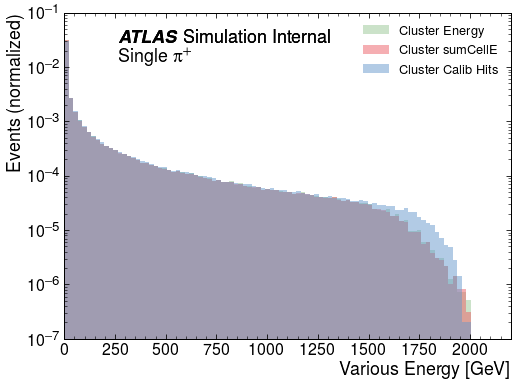

In [9]:
pu.histogramOverlay(frames = [pp, pp, pp],
                    data =  ['clusterE', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT'],
                    labels =['Cluster Energy', 'Cluster sumCellE', 'Cluster Calib Hits'],
                    xlabel = 'Various Energy [GeV]',
                    ylabel = 'Events (normalized)',
                    figfile = plotpath + '/hist_energy.pdf',
                    x_min = 0, x_max = 2200, xbins = 100, normed = True, y_log = True,
                    atlas_x = 0.12, atlas_y = 0.95, simulation = True,
                    textlist = [{'x': 0.12, 'y': 0.85, 'text': 'Single $\pi^{+}$'}])

## Let's make some response plots now!

This is what we wanted! Nice. Can see the shapes that we expect. Let's wrap this all into a function.

<Figure size 576x432 with 0 Axes>

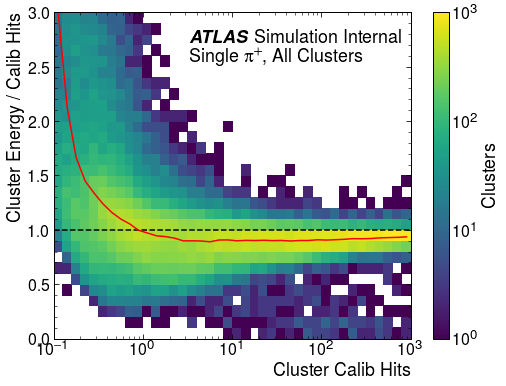

In [60]:
xcenter, medBase = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                      pp[pp.test].clusterEoverCalib, 
                      figfile = plotpath+'hist_2D_calib_vs_ratio_pp_profile.pdf', statistic = 'median',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'}])

In [ ]:
Above, we can see the dip below 1 at 2-5 GeV, the rise to 1 above that, and the rise way above 1 below that. Interesting!

<Figure size 576x432 with 0 Axes>

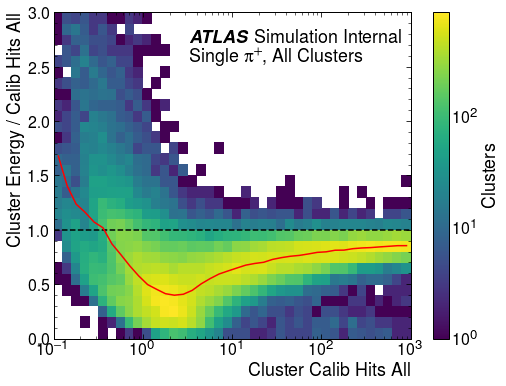

In [62]:
xcenter, medAll = ru.responsePlot(pp[pp.test].cluster_ENG_ALL, 
                      pp[pp.test].clusterE / pp[pp.test].cluster_ENG_ALL, 
                      figfile = plotpath+'hist_2D_calibAll_vs_ratioAll_pp_profile.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits All', ylabel = 'Cluster Energy / Calib Hits All',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'}])

We see it's way lower! Could it be that when the energy / true is very high in the previous plot, it's because "true" is missing energy outside the cluster or in the dead material? But the cluster itself shoudln't be picking that up. Weird.

<Figure size 576x432 with 0 Axes>

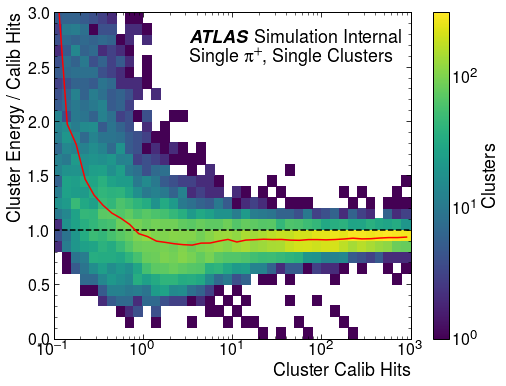

In [63]:
xcenter, medSingleBase = ru.responsePlot(pp[pp.test & pp.Single].cluster_ENG_CALIB_TOT, 
                         pp[pp.test & pp.Single].clusterEoverCalib, 
                         figfile = plotpath+'hist_2D_calib_vs_ratio_pp_profile_Single.pdf', statistic = 'median',
                         atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                         textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'}])

<Figure size 576x432 with 0 Axes>

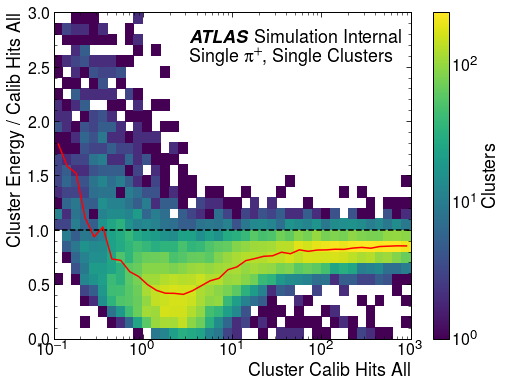

In [64]:
xcenter, medSingleAll = ru.responsePlot(pp[pp.test & pp.Single].cluster_ENG_ALL, 
                      pp[pp.test & pp.Single].clusterE / pp[pp.test & pp.Single].cluster_ENG_ALL, 
                      figfile = plotpath+'hist_2D_calibAll_vs_ratioAll_pp_profile_Single.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits All', ylabel = 'Cluster Energy / Calib Hits All',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'}])

<Figure size 576x432 with 0 Axes>

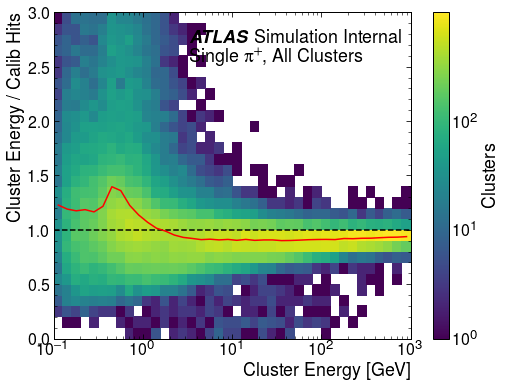

In [65]:
xcenter, medBase_E = ru.responsePlot(pp[pp.test].clusterE,
                      pp[pp.test].clusterE / pp[pp.test].cluster_ENG_CALIB_TOT, 
                      figfile = plotpath+'hist_2D_E_vs_ratio_pp_profile.pdf', statistic = 'median',
                      xlabel = 'Cluster Energy [GeV]', ylabel = 'Cluster Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'}])

## Let's implement the basic regression again!

In [15]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

Number of devices: 2


Need to remember to use the strategy context everywhere, or else the multi-gpu isn't used, but the batch size is increased!!!

In [120]:
# Define a very basic regression: one input, one output
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

def baseline_model():
    with strategy.scope():
        regressor = Sequential()
        regressor.add(Dense(units=24, input_dim=1, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=24, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        regressor.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])

    return regressor

In [121]:
from keras.wrappers.scikit_learn import KerasRegressor

regressor = KerasRegressor(build_fn=baseline_model, batch_size=200*ngpu, epochs=50, verbose=1)
print(baseline_model().summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 24)                48        
_________________________________________________________________
dense_16 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 25        
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________
None


In [122]:
history_baseline = regressor.fit([pp[pp.train].s_logE.to_numpy()], pp[pp.train].s_logECalib.to_numpy())

Train on 348773 samples
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
348773/348773 [==============================] - 8s 24us/sample - loss: 0.6603 - mae: 0.6600 - mse: 0.6603
Epoch 2/50
348773/348773 [==============================] - 5s 15us/sample - loss: 0.0591 - mae: 0.1652 - mse: 0.0591
Epoch 3/50
348773/348773 [==============================] - 5s 15us/sample - loss: 0.0405 - mae: 0.1419 - mse: 0.0405
Epoch 4/50
348773/348773 [==============================] - 5s 15us/sample - loss: 0.0387 - mae: 0.1346 - mse: 0.0387
Epoch 5/50
348773/348773 [==============================] - 5s 15us/sample - loss: 0.0371 - mae: 0.1250 - mse: 0.0371
Epoch 6/50
348773/348773 [==============================] - 5s 15us/sample - loss: 0

In [125]:
pp['predict_base_E'] = np.exp(scaler_cal.inverse_transform(regressor.predict([pp.s_logE.to_numpy()])))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

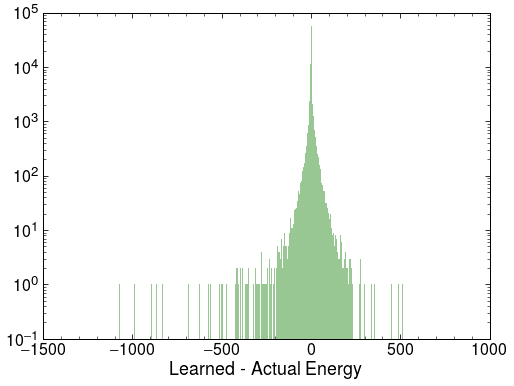

In [50]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pp[pp.test].predict_base_E-pp[pp.test].cluster_ENG_CALIB_TOT,bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - Actual Energy')
plt.legend()
plt.show()

No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

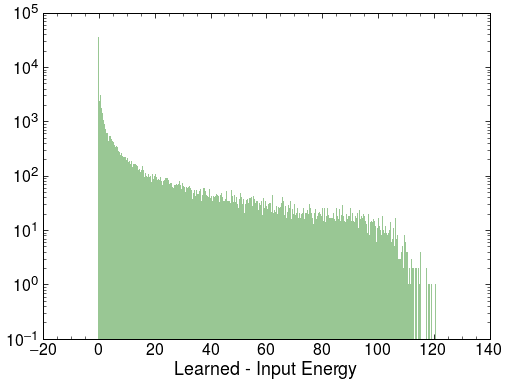

In [51]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pp[pp.test].predict_base_E-pp[pp.test].clusterE,bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - Input Energy')
plt.legend()
plt.show()

In [126]:
pp['predict_base_EoverCalib'] = pp.predict_base_E / pp.cluster_ENG_CALIB_TOT

<Figure size 576x432 with 0 Axes>

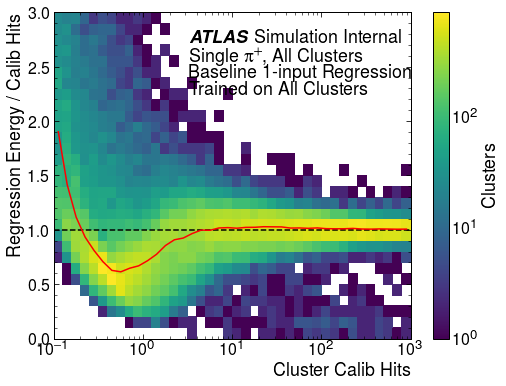

In [53]:
xcenter, medReg = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, 
                      pp[pp.test].predict_base_EoverCalib,
                      figfile = plotpath+'hist_2D_calib_vs_ratioReg_pp_profile.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

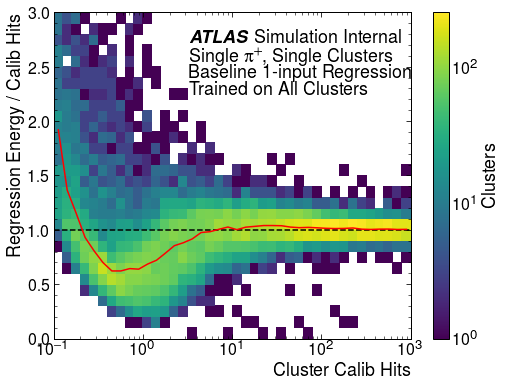

In [109]:
xcenter, medRegSingle = ru.responsePlot(pp[pp.test & pp.Single].cluster_ENG_CALIB_TOT, 
                      pp[pp.test & pp.Single].predict_base_EoverCalib,
                      figfile = plotpath+'hist_2D_calib_vs_ratioReg_pp_profile_Single.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

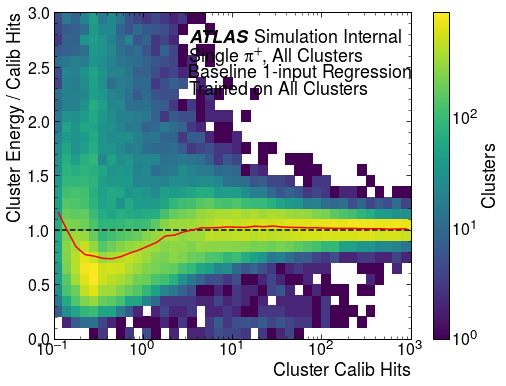

In [55]:
xcenter, medReg_E = ru.responsePlot(pp[pp.test].predict_base_E,
                      pp[pp.test].predict_base_EoverCalib,
                      figfile = plotpath+'hist_2D_regE_vs_ratioReg_pp_profile.pdf', statistic = 'median',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                      {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

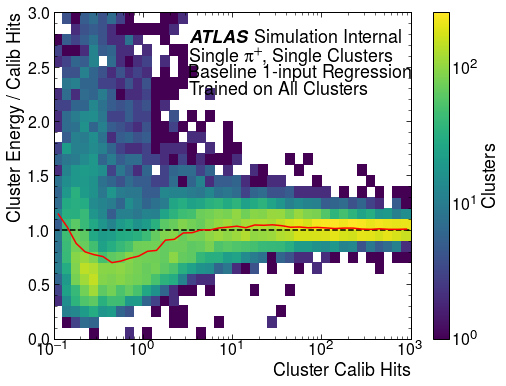

In [56]:
xcenter, medRegSingle_E = ru.responsePlot(pp[pp.test & pp.Single].predict_base_E,
                      pp[pp.test & pp.Single].predict_base_EoverCalib,
                      figfile = plotpath+'hist_2D_regE_vs_ratioReg_pp_profile_Single.pdf', statistic = 'median',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'},
                      {'x': 0.38, 'y': 0.8,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

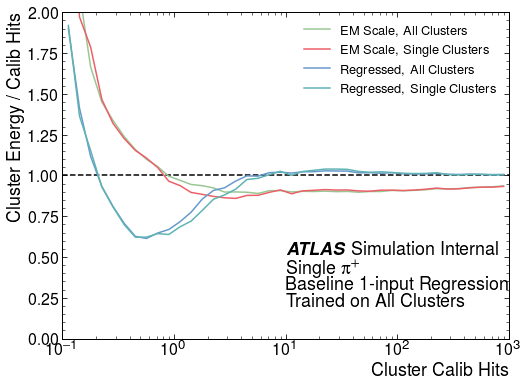

In [66]:
pu.lineOverlay(xcenter=xcenter, lines = [medBase, medSingleBase, medReg, medRegSingle],
                labels = ['EM Scale, All Clusters', 'EM Scale, Single Clusters', 'Regressed, All Clusters', 'Regressed, Single Clusters'],
                xlabel = 'Cluster Calib Hits', ylabel = 'Cluster Energy / Calib Hits',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_profile_Overlay_BaseRegSingle.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$'},
                                  {'x': 0.5, 'y': 0.15,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.5, 'y': 0.1, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

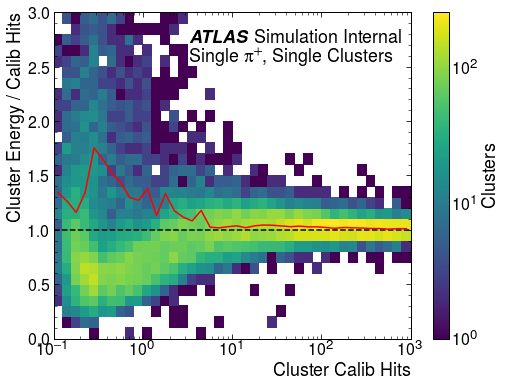

([0.11294627058970837,
  0.14219093021276402,
  0.17900777537149964,
  0.22535743732392294,
  0.2837082045838979,
  0.3571674682851675,
  0.44964720209038467,
  0.5660722890537326,
  0.7126427896022371,
  0.8971641173621403,
  1.1294627058970828,
  1.4219093021276392,
  1.7900777537149957,
  2.2535743732392284,
  2.837082045838977,
  3.5716746828516728,
  4.496472020903845,
  5.660722890537324,
  7.126427896022365,
  8.971641173621396,
  11.294627058970825,
  14.219093021276386,
  17.90077753714994,
  22.53574373239227,
  28.370820458389765,
  35.716746828516726,
  44.96472020903842,
  56.60722890537319,
  71.26427896022365,
  89.71641173621393,
  112.94627058970815,
  142.1909302127638,
  179.00777537149938,
  225.35743732392268,
  283.7082045838975,
  357.16746828516693,
  449.647202090384,
  566.0722890537315,
  712.6427896022358,
  897.1641173621388],
 array([1.34103313, 1.26101804, 1.15968067, 1.34224995, 1.75330546,
        1.64738884, 1.51863896, 1.43301162, 1.29642034, 1.272131

In [58]:
#for completelness, test the mean, but nothing crazy
ru.responsePlot(pp[pp.test & pp.Single].predict_base_E,
                      pp[pp.test & pp.Single].predict_base_EoverCalib,
                      statistic = 'mean',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'}])

<Figure size 576x432 with 0 Axes>

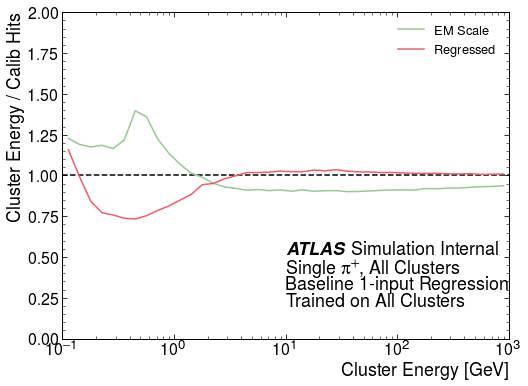

In [67]:
pu.lineOverlay(xcenter=xcenter, lines = [medBase_E, medReg_E],
                labels = ['EM Scale', 'Regressed'],
                xlabel = 'Cluster Energy [GeV]', ylabel = 'Cluster Energy / Calib Hits',
                figfile = plotpath + "hist_2D_e_vs_ratio_pp_profile_Overlay_BaseReg.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15,  'text': 'Baseline 1-input Regression'},
                                  {'x': 0.5, 'y': 0.1, 'text': 'Trained on All Clusters'}])

## Now let's do resolution plots!

<Figure size 576x432 with 0 Axes>

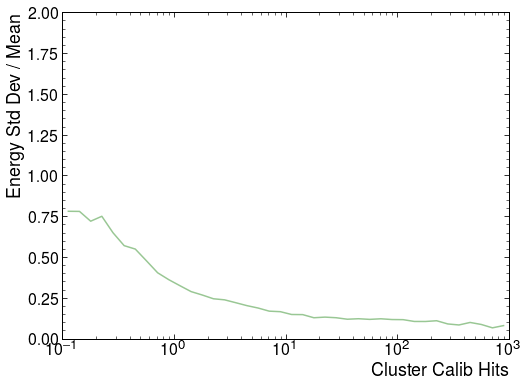

<Figure size 576x432 with 0 Axes>

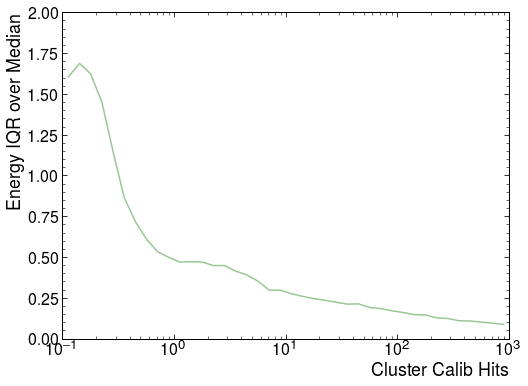

In [68]:
xcenter, stdOverMeanBase = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].clusterEoverCalib,
                plotpath+'hist_2D_calib_vs_ratio_pp_stdMean', statistic='stdOverMean',
                ylabel = 'Energy Std Dev / Mean')
xcenter, iqrOverMedBase = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].clusterEoverCalib,
                plotpath+'hist_2D_calib_vs_ratio_pp_iqrMed', statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

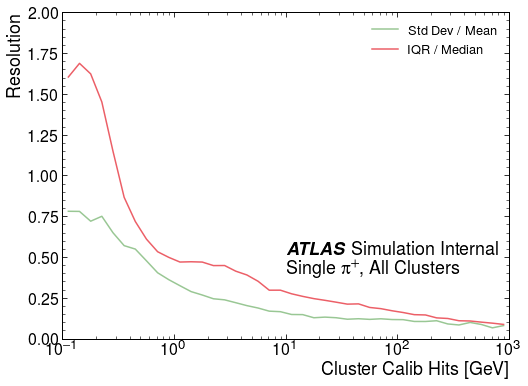

In [69]:
pu.lineOverlay(xcenter=xcenter, lines = [stdOverMeanBase, iqrOverMedBase],
                labels = ['Std Dev / Mean', 'IQR / Median'],
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Resolution',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_IQRSTD.pdf",
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'}])

<Figure size 576x432 with 0 Axes>

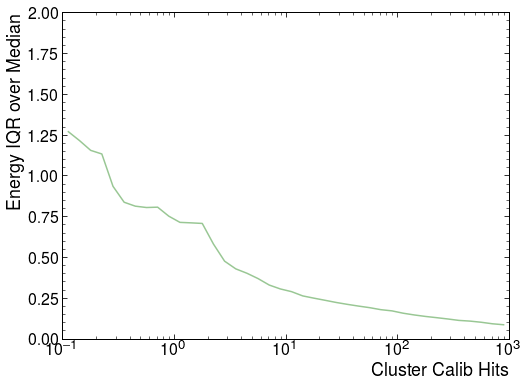

<Figure size 576x432 with 0 Axes>

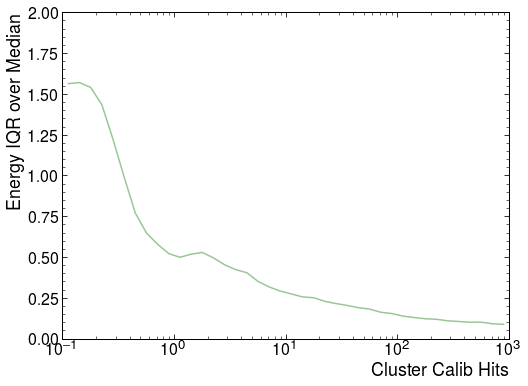

<Figure size 576x432 with 0 Axes>

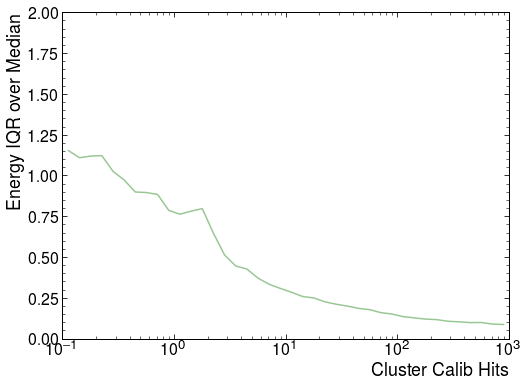

In [128]:
xcenter, iqrOverMedReg = ru.resolutionPlot(pp.cluster_ENG_CALIB_TOT,  pp.predict_base_E / pp.cluster_ENG_CALIB_TOT, statistic='iqrOverMed')
xcenter, iqrOverMedSingle = ru.resolutionPlot(pp[pp.Single].cluster_ENG_CALIB_TOT,  pp[pp.Single].clusterE / pp[pp.Single].cluster_ENG_CALIB_TOT, statistic='iqrOverMed')
xcenter, iqrOverMedRegSingle = ru.resolutionPlot(pp[pp.Single].cluster_ENG_CALIB_TOT,  pp[pp.Single].predict_base_E/ pp[pp.Single].cluster_ENG_CALIB_TOT, statistic='iqrOverMed')

Now we can compare how we're doing with the original resolution, and the regressed one:

<Figure size 576x432 with 0 Axes>

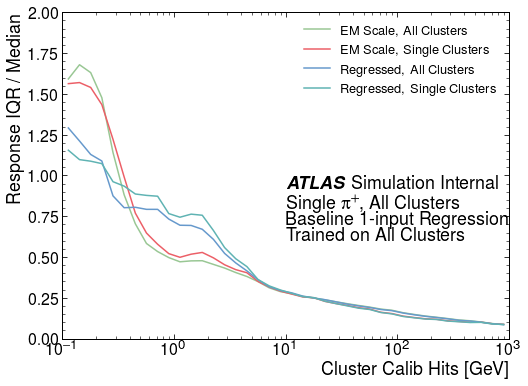

In [76]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMedBase, iqrOverMedSingle, iqrOverMedReg, iqrOverMedRegSingle],
                labels = ['EM Scale, All Clusters', 'EM Scale, Single Clusters', 'Regressed, All Clusters', 'Regressed, Single Clusters'],
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response IQR / Median',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegSingle.pdf",
                atlas_x = 0.5, atlas_y = 0.5, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Single $\pi^{+}$, All Clusters'},
                            {'x': 0.5, 'y': 0.35,  'text': 'Baseline 1-input Regression'},
                            {'x': 0.5, 'y': 0.3, 'text': 'Trained on All Clusters'}])

That looks interesting. Some variation at low, probably due to the huge movements up/down we have. But later on, no improvement-- expected because we're only regressing on energy.

Regression is doing worse on single clusters, though to be fair, the original single clusters had worse resolution there too. Need to test training on single, applying to all, as well.

## Let's add one feature to the regressor

Just to keep it simple, we can make this the LC EM Probability, and see how we do

In [70]:
def baseline_wlc_model():
    with strategy.scope():
        regressor = Sequential()
        regressor.add(Dense(units=24, input_dim=2, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=24, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        regressor.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])

    return regressor

In [71]:

regressor_wlc = KerasRegressor(build_fn=baseline_wlc_model, batch_size=200*ngpu, epochs=100, verbose=1)
print(baseline_wlc_model().summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 24)                72        
_________________________________________________________________
dense_10 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 25        
Total params: 697
Trainable params: 697
Non-trainable params: 0
_________________________________________________________________
None


Will I have to normalize the LC EM prob? try without first. Ok that was really trash. Try again. Still trash! What the hecks. Do some exploring of the variable.

In [27]:
scaler_emprob = StandardScaler()

# fit and transform in one step
standardized_emprob = scaler_emprob.fit_transform(pp['cluster_EM_PROBABILITY'].reshape(-1,1))

In [28]:
np.reshape(standardized_energy_l,len(standardized_energy_l))

array([ 2.19654098,  0.88410782, -1.1032541 , ...,  0.78373167,
        0.0807608 ,  0.01653406])

<Figure size 432x288 with 0 Axes>

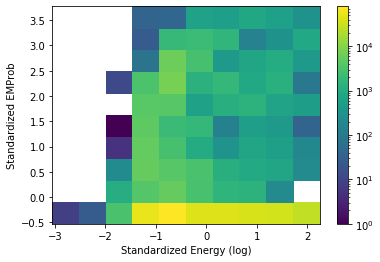

In [25]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist2d(np.reshape(standardized_energy_l,len(standardized_energy_l)),
            np.reshape(standardized_emprob, len(standardized_emprob)),norm=LogNorm())
# plt.plot(xcenter, profileXMed)
# plt.plot([0.1,1000],[1,1],linestyle='--')
# plt.xscale('log')
# plt.ylim(0,3)
plt.xlabel('Standardized Energy (log)')
plt.ylabel('Standardized EMProb')
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

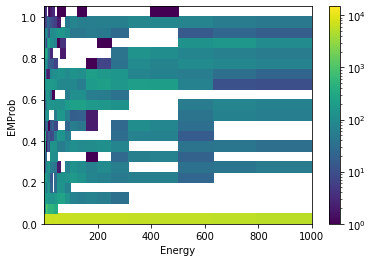

In [28]:
xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
ybin = np.arange(0., 1.1, 0.05)

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist2d(pp['clusterE'], pp['cluster_EM_PROBABILITY'],bins=[xbin, ybin], norm=LogNorm())
# plt.plot(xcenter, profileXMed)
# plt.plot([0.1,1000],[1,1],linestyle='--')
# plt.xscale('log')
# plt.ylim(0,3)
plt.xlabel('Energy')
plt.ylabel('EMProb')
plt.colorbar()
plt.show()

Ok, the above is probably why this isn't working... everything is close to 0!

In [29]:
#previous cleaned EM Prob here, but we do it already above now

0
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

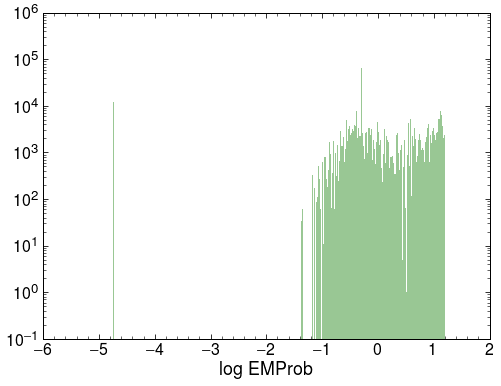

In [85]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pp.s_logEM,bins = n_bins)
plt.yscale('log')
plt.xlabel('log EMProb')
plt.legend()
plt.show()

Train the regressor with the LC input here. Standardization of the emprob done above. Now we are also cleaning particularly bad cases.

In [87]:
np.column_stack((pp.s_logE,pp.s_logEM))
# standardized_calib_lc = standardized_calib_l[~np.isinf(emprob_l)]

array([[ 2.1965618 ,  0.34173584],
       [ 0.88413787, -0.28239137],
       [-1.1032102 , -0.38423893],
       ...,
       [ 0.7511476 , -0.22514166],
       [-0.02270268,  1.1635797 ],
       [-0.5839853 , -0.5266188 ]], dtype=float32)

In [92]:
pp[['s_logE','s_logEM']].to_numpy()

array([[ 2.1965618 ,  0.34173584],
       [ 0.88413787, -0.28239137],
       [-1.1032102 , -0.38423893],
       ...,
       [ 0.7511476 , -0.22514166],
       [-0.02270268,  1.1635797 ],
       [-0.5839853 , -0.5266188 ]], dtype=float32)

In [93]:
history_baseline_wlc = regressor_wlc.fit(pp[pp.train][['s_logE','s_logEM']].to_numpy(), pp[pp.train].s_logECalib.to_numpy())

Train on 348773 samples
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
348773/348773 [==============================] - 8s 24us/sample - loss: 0.6180 - mae: 0.6282 - mse: 0.6180
Epoch 2/100
348773/348773 [==============================] - 5s 14us/sample - loss: 0.0424 - mae: 0.1475 - mse: 0.0424
Epoch 3/100
348773/348773 [==============================] - 5s 15us/sample - loss: 0.0320 - mae: 0.1243 - mse: 0.0320
Epoch 4/100
348773/348773 [==============================] - 5s 14us/sample - loss: 0.0301 - mae: 0.1163 - mse: 0.0301
Epoch 5/100
348773/348773 [==============================] - 5s 15us/sample - loss: 0.0289 - mae: 0.1090 - mse: 0.0289
Epoch 6/100
348773/348773 [==============================] - 5s 15us/sample - l

In [98]:
                            # np.exp(scaler_cal.inverse_transform(regressor.predict([pp.s_logE.to_numpy()])))
pp['predict_base_wlc_E'] = np.exp(scaler_cal.inverse_transform(regressor_wlc.predict([pp[['s_logE','s_logEM']].to_numpy()])))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

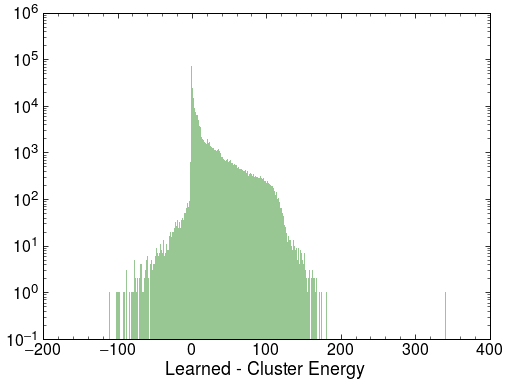

In [99]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pp.predict_base_wlc_E-pp.clusterE,bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - Cluster Energy')
plt.legend()
plt.show()

No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

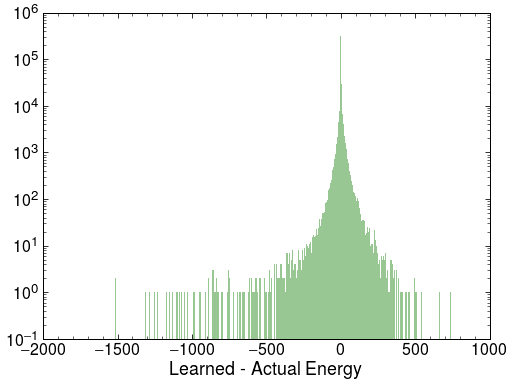

In [100]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(pp.predict_base_wlc_E-pp.cluster_ENG_CALIB_TOT,bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - Actual Energy')
plt.legend()
plt.show()

In [101]:
pp['predict_base_wlc_EoverCalib'] = pp.predict_base_wlc_E / pp.cluster_ENG_CALIB_TOT

<Figure size 576x432 with 0 Axes>

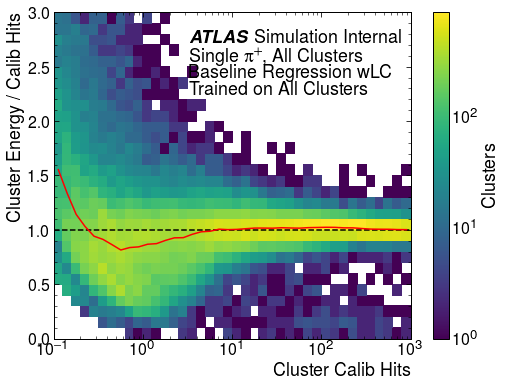

In [105]:
xcenter, medRegwLC = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_base_wlc_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_wlc_pp_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'Baseline Regression wLC'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

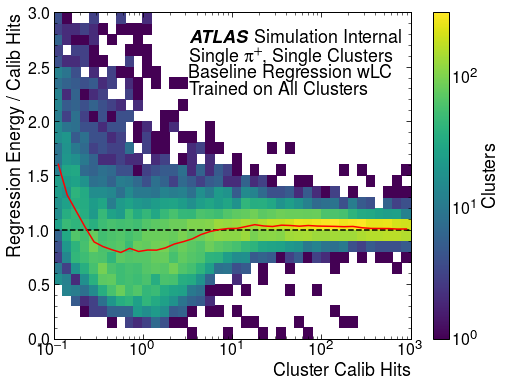

In [108]:
xcenter, medRegwLCSingle = ru.responsePlot(pp[pp.test & pp.Single].cluster_ENG_CALIB_TOT, 
                      pp[pp.test & pp.Single].predict_base_wlc_EoverCalib,
                      figfile = plotpath+'hist_2D_calib_vs_ratioReg_wlc_pp_profile_Single.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, Single Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'Baseline Regression wLC'},
                                  {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

Hah, it works!! I was just not re-evaluating it properly last time. It was the regularization: absolutely have to log and regularize everything.

Let's make plots comparing scales and resolutions. TODO: add info to arrays for the hadronic calibration alone, not the total energy.

<Figure size 576x432 with 0 Axes>

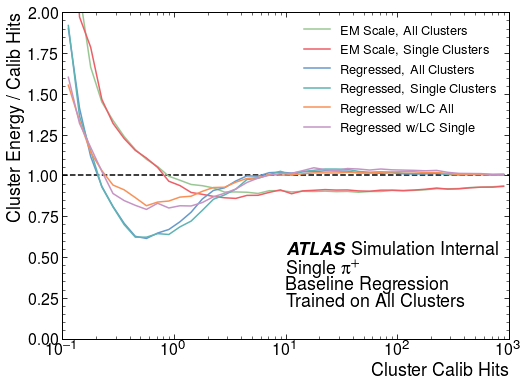

In [110]:
pu.lineOverlay(xcenter=xcenter, lines = [medBase, medSingleBase, medReg, medRegSingle, medRegwLC, medRegwLCSingle],
                labels = ['EM Scale, All Clusters', 'EM Scale, Single Clusters', 'Regressed, All Clusters', 'Regressed, Single Clusters', 'Regressed w/LC All', 'Regressed w/LC Single'],
                xlabel = 'Cluster Calib Hits', ylabel = 'Cluster Energy / Calib Hits',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_profile_Overlay_BaseRegLCSingle.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$'},
                                  {'x': 0.5, 'y': 0.15,  'text': 'Baseline Regression'},
                                  {'x': 0.5, 'y': 0.1, 'text': 'Trained on All Clusters'}])

<Figure size 576x432 with 0 Axes>

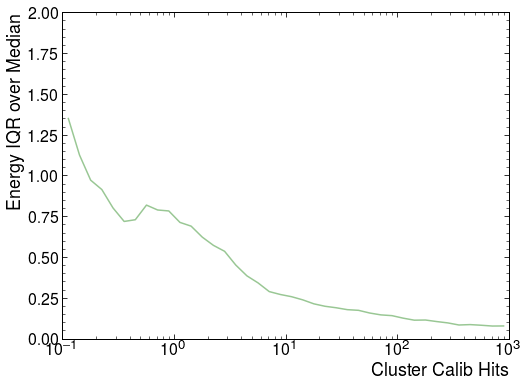

In [112]:
xcenter, iqrOverMedRegwlc = ru.resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT,
                                                pp[pp.test].predict_base_wlc_EoverCalib,
                                                plotpath+'hist_2D_calib_vs_baselineregwLCratio_pp_iqrMed.pdf', statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

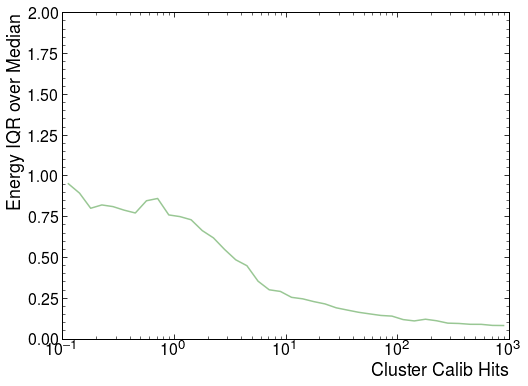

In [113]:
xcenter, iqrOverMedRegwlcSingle = ru.resolutionPlot(pp[pp.Single & pp.test].cluster_ENG_CALIB_TOT,
                                                pp[pp.Single & pp.test].predict_base_wlc_EoverCalib,
                                                plotpath+'hist_2D_calib_vs_baselineregwLCratio_pp_iqrMed_Single.pdf', statistic='iqrOverMed')

<Figure size 576x432 with 0 Axes>

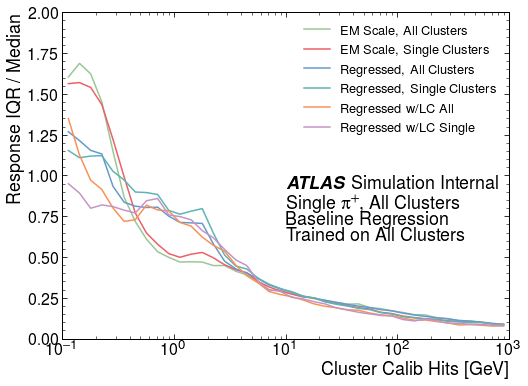

In [129]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMedBase, iqrOverMedSingle, iqrOverMedReg, iqrOverMedRegSingle, iqrOverMedRegwlc, iqrOverMedRegwlcSingle],
                labels = ['EM Scale, All Clusters', 'EM Scale, Single Clusters', 'Regressed, All Clusters', 'Regressed, Single Clusters', 'Regressed w/LC All', 'Regressed w/LC Single'],
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response IQR / Median',
                figfile = plotpath + "hist_2D_calib_vs_ratio_pp_res_Overlay_BaseRegSingle.pdf",
                atlas_x = 0.5, atlas_y = 0.5, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.4, 'text': 'Single $\pi^{+}$, All Clusters'},
                            {'x': 0.5, 'y': 0.35,  'text': 'Baseline Regression'},
                            {'x': 0.5, 'y': 0.3, 'text': 'Trained on All Clusters'}])

Better scale, and better resolution! Amazing. Should understand why near 1-5 GeV we get the bump in the resolution-- we do worse than EM scale. Possibly related to 'single cluster' issues there? Also of note, Single still pretty consistent to All, in the evaluation

## Let's add η to the regressor

This could have an impact-- knowing where in the detector you are should have a response impact!

In [40]:
scaler_eta = StandardScaler()

# fit and transform in one step
standardized_eta= scaler_eta.fit_transform(pp['clusterEta'].reshape(-1,1))

In [41]:
input_wlceta = np.column_stack((standardized_energy_l,standardized_emprob_lc,standardized_eta))


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

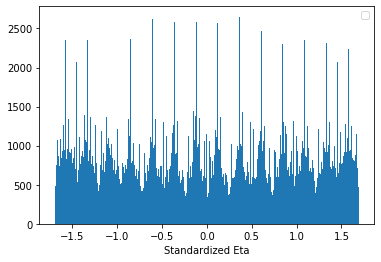

In [42]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(standardized_eta,bins = n_bins)
# plt.yscale('log')
plt.xlabel('Standardized Eta')
plt.legend()
plt.show()

In [43]:
def baseline_wlceta_model():
    with strategy.scope():
        regressor = Sequential()
        regressor.add(Dense(units=36, input_dim=3, kernel_initializer='normal',                     activation='relu'))
        regressor.add(Dense(units=36, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        regressor.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])

    return regressor

In [44]:
regressor_wlceta = KerasRegressor(build_fn=baseline_wlceta_model, batch_size=200*ngpu, epochs=100, verbose=1)
print(baseline_wlceta_model().summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 36)                144       
_________________________________________________________________
dense_19 (Dense)             (None, 36)                1332      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 37        
Total params: 1,513
Trainable params: 1,513
Non-trainable params: 0
_________________________________________________________________
None


In [45]:

history_baseline_wlceta = regressor_wlceta.fit(input_wlceta, standardized_calib_l)

Train on 435489 samples
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
435489/435489 [==============================] - 10s 22us/sample - loss: 0.3999 - mae: 0.4471 - mse: 0.3999
Epoch 2/100
435489/435489 [==============================] - 7s 15us/sample - loss: 0.0324 - mae: 0.1250 - mse: 0.0324
Epoch 3/100
435489/435489 [==============================] - 7s 15us/sample - loss: 0.0294 - mae: 0.1111 - mse: 0.0294
Epoch 4/100
435489/435489 [==============================] - 7s 15us/sample - loss: 0.0278 - mae: 0.1024 - mse: 0.0278
Epoch 5/100
435489/435489 [==============================] - 7s 15us/sample - loss: 0.0270 - mae: 0.0981 - mse: 0.0270
Epoch 6/100
435489/435489 [==============================] - 7s 15us/sample - 

In [46]:
predict_base_wlceta_pp = np.exp(scalar_cal.inverse_transform(regressor_wlceta.predict(input_wlceta)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

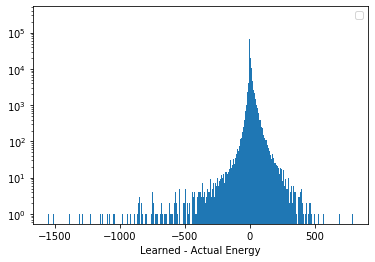

In [47]:
n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(predict_base_wlceta_pp-pp['cluster_ENG_CALIB_TOT'],bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - Actual Energy')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

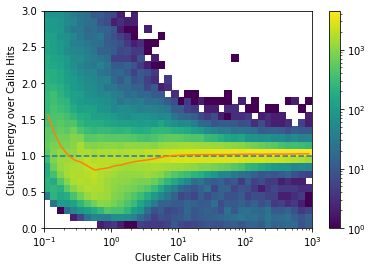

In [48]:
xcenter, medRegwLCEta = ru.responsePlot(pp['cluster_ENG_CALIB_TOT'], predict_base_wlceta_pp/pp['cluster_ENG_CALIB_TOT'],
                 plotpath+'hist_2D_calib_vs_baselinereg_wlceta_ratio_pp_profile',
                 'median')

Got some real problematic few events that got really mssed up, but acting well besides that

<Figure size 432x288 with 0 Axes>

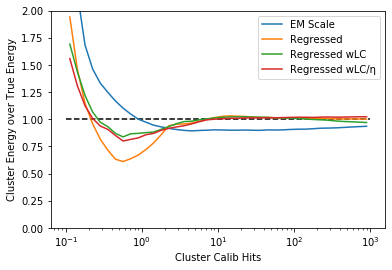

In [49]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0.1, 1000], [1, 1], linestyle='--',color='black')
plt.plot(xcenter, medBase, label = 'EM Scale')
plt.plot(xcenter, medReg, label = 'Regressed')
plt.plot(xcenter, medRegwLC, label = 'Regressed wLC')
plt.plot(xcenter, medRegwLCEta, label = 'Regressed wLC/η')
plt.xscale('log')
plt.ylim(0,2)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Energy over True Energy')
plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_scale_pp_EMvsRegwLCEta.pdf')
plt.show()

Scale didnt' change too much, but that's fine

<Figure size 432x288 with 0 Axes>

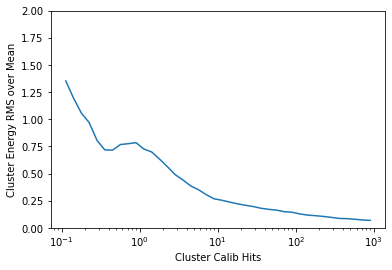

In [50]:
xcenter, iqrOverMedGRegwlceta = ru.resolutionPlot(pp['cluster_ENG_CALIB_TOT'], 
                                                predict_base_wlceta_pp/pp['cluster_ENG_CALIB_TOT'],
                                                plotpath+'ist_2D_calib_vs_baselineregwLCEtaratio_pp_iqrMed', statistic='iqrOverMed')

<Figure size 432x288 with 0 Axes>

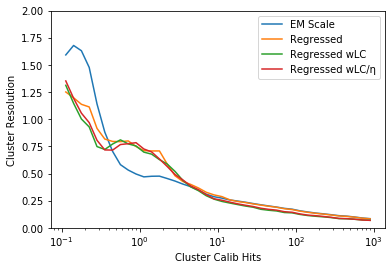

In [51]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(xcenter, iqrOverMedG, label = 'EM Scale')
plt.plot(xcenter, iqrOverMedGReg, label = 'Regressed')
plt.plot(xcenter, iqrOverMedGRegwlc, label = 'Regressed wLC')
plt.plot(xcenter, iqrOverMedGRegwlceta, label = 'Regressed wLC/η')
plt.xscale('log')
plt.ylim(0,2)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Resolution')
plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_resolution_pp_EMvsRegwLCEta.pdf')
plt.show()

Not really appreciable differences here

In [52]:
#let's save the models to save time in the future
#g1 is with gpu1, otherwise nominal with 2gpu. those are fun.
regressor.model.save(modelpath+'baseline.h5')
regressor_wlc.model.save(modelpath+'baseline_wlc.h5')
regressor_wlceta.model.save(modelpath+'baseline_wlceta.h5')

In [66]:
#this loads the models to save time
from keras.models import load_model
regressor.model = load_model(modelpath+'baseline.h5')
regressor_wlc.model = load_model(modelpath+'baseline_wlc.h5')
regressor_wlceta.model = load_model(modelpath+'baselne_wlceta.h5')

## Compare to LC now!

<Figure size 432x288 with 0 Axes>

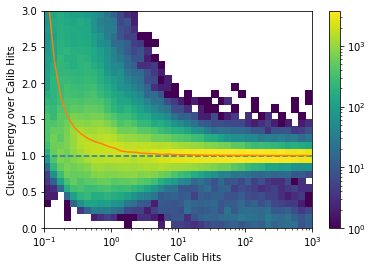

In [53]:
xcenter, medBaseLC = ru.responsePlot(pp['cluster_ENG_CALIB_TOT'], 
                        (pp['clusterE'] * pp['cluster_HAD_WEIGHT'])/pp['cluster_ENG_CALIB_TOT'],
                        plotpath+'hist_2D_calib_vs_baselineregratio_pp_profile',
                        'median')

<Figure size 432x288 with 0 Axes>

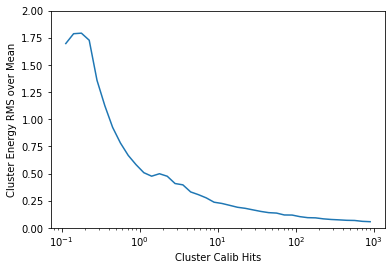

In [54]:
xcenter, iqrOverMedGLC = ru.resolutionPlot(pp['cluster_ENG_CALIB_TOT'], 
                            (pp['clusterE'] * pp['cluster_HAD_WEIGHT'])/pp['cluster_ENG_CALIB_TOT'],
                            plotpath+'hist_2D_calib_vs_ratio_pp_iqrMed', statistic='iqrOverMed')

<Figure size 432x288 with 0 Axes>

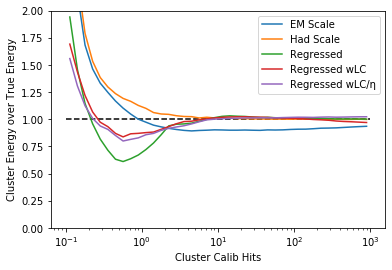

In [55]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0.1, 1000], [1, 1], linestyle='--',color='black')
plt.plot(xcenter, medBase, label = 'EM Scale')
plt.plot(xcenter, medBaseLC, label = 'Had Scale')
plt.plot(xcenter, medReg, label = 'Regressed')
plt.plot(xcenter, medRegwLC, label = 'Regressed wLC')
plt.plot(xcenter, medRegwLCEta, label = 'Regressed wLC/η')
plt.xscale('log')
plt.ylim(0,2)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Energy over True Energy')
plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_scale_pp_EMHadvsRegwLCEta.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

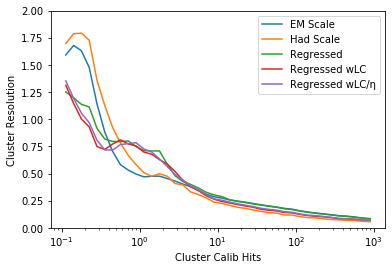

In [56]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(xcenter, iqrOverMedG, label = 'EM Scale')
plt.plot(xcenter, iqrOverMedGLC, label = 'Had Scale')
plt.plot(xcenter, iqrOverMedGReg, label = 'Regressed')
plt.plot(xcenter, iqrOverMedGRegwlc, label = 'Regressed wLC')
plt.plot(xcenter, iqrOverMedGRegwlceta, label = 'Regressed wLC/η')
plt.xscale('log')
plt.ylim(0,2)
plt.xlabel('Cluster Calib Hits')
plt.ylabel('Cluster Resolution')
plt.legend()
plt.savefig(plotpath+'/hist_2D_calib_vs_resolution_pp_EMHadvsRegwLCEta.pdf')
plt.show()

Neat. See the worse resolution at low values!